In [ ]:
import os
import patchconvnet_models as patch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import optuna


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_epochs = 16
num_classes = 100
lr = 1e-4
num_workers = 4

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def train(model, train_loader, epochs=10,lr=1e-3,weight_decay=0.01):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    train_loss = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss/batch_size
        train_loss.append(epoch_loss)
    plt.plot([x for x in range(epoch+1)],train_loss)
    plt.xlabel("num_epochs")
    plt.ylabel("Loss")
    plt.title("training_loss")
    plt.show()

In [15]:
def evaluate(model, dataloader):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, pred = outputs.topk(5, 1, True, True)
            total += y.size(0)
            top1_correct += (pred[:, 0] == y).sum().item()
            top5_correct += sum([y[i] in pred[i] for i in range(y.size(0))])

    return top1_correct / total, top5_correct / total

Dobór hiperparametrów

Podstawowy trenig czy sie wykonuje

S60_MLA


100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


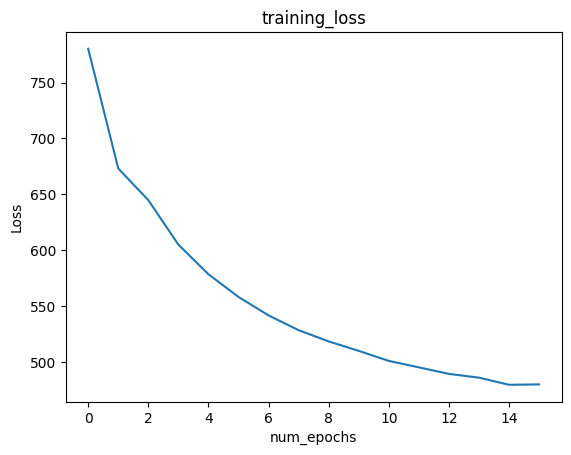

100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


In [16]:
model_orig = patch.S60_MLA(num_classes=num_classes, pretrained=False)
print("S60_MLA")
train(model_orig, train_loader, epochs=num_epochs)
acc1_orig, acc5_orig = evaluate(model_orig,test_loader )

In [17]:
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")

Oryginalny model  - Top1: 0.5521 | Top5: 0.9510


S60_MLA_LR


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


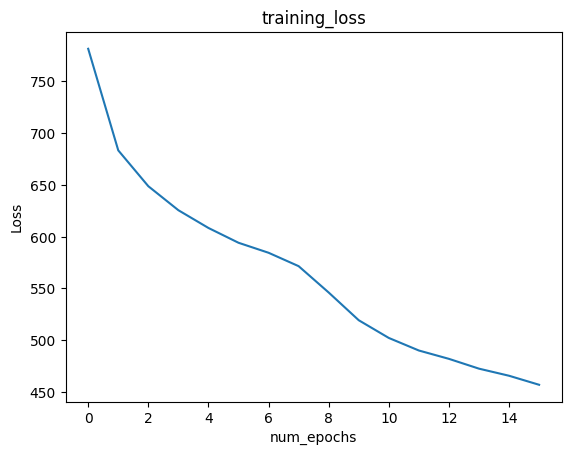

100%|██████████| 79/79 [00:17<00:00,  4.63it/s]


In [18]:
model_orig = patch.S60_MLA_LR(num_classes=num_classes,low_rank_dim=32, pretrained=False)
print("S60_MLA_LR")
train(model_orig, train_loader, epochs=num_epochs)
acc1_orig, acc5_orig = evaluate(model_orig,test_loader )

In [19]:
print(f"Model z low rank kv compresion: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")


Model z low rank kv compresion: 0.5765 | Top5: 0.9564


Trening hiperparametrów z wykorzystaniem optuny

In [20]:
def objective(trial):
    # Propozycje hiperparametrów
    drop_path = trial.suggest_float("drop_path_rate", 0.0, 0.5)
    lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
    low_rank_dim = trial.suggest_categorical("low_rank_dim", [None, 32, 64, 96])
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    depth_token_only = trial.suggest_int("depth_token_only", 1, 3)

    model = patch.S60_MLA_LR(
        drop_path_rate=drop_path,
        num_heads=num_heads,
        depth_token_only=depth_token_only,
        low_rank_dim = low_rank_dim
    )
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Walidacja
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return 1.0 - accuracy  # ponieważ Optuna minimalizuje

In [21]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("Najlepsze parametry:", study.best_params)

[I 2025-06-11 02:06:57,807] A new study created in memory with name: no-name-a03021b9-8942-4d32-8469-7ee593c187a7
C:\Users\stasi\AppData\Local\Temp\ipykernel_34144\773594708.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\stasi\AppData\Local\Temp\ipykernel_34144\773594708.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
[I 2025-06-11 02:31:21,923] Trial 0 finished with value: 0.3288 and parameters: {'drop_path_rate': 0.3434031361431554, 'learning_rate': 0.00316751056467714, 'weight_decay': 0.008616829146696571, 'low_rank_dim': 96

Najlepsze parametry: {'drop_path_rate': 0.04526393819335772, 'learning_rate': 0.00039656376220750735, 'weight_decay': 1.7971498867966095e-06, 'low_rank_dim': 32, 'num_heads': 8, 'depth_token_only': 1}


Wybrane parametry

In [22]:
best_params = study.best_params

drop_path = best_params["drop_path_rate"]
lr = best_params["learning_rate"]
weight_decay = best_params["weight_decay"]
num_heads = best_params["num_heads"]
depth_token_only = best_params["depth_token_only"]

# Parametr specyficzny tylko dla wersji low-rank
low_rank_dim = best_params["low_rank_dim"]

num_epochs = 20

Testy ablacyjne

MLA


100%|██████████| 391/391 [00:59<00:00,  6.59it/s]


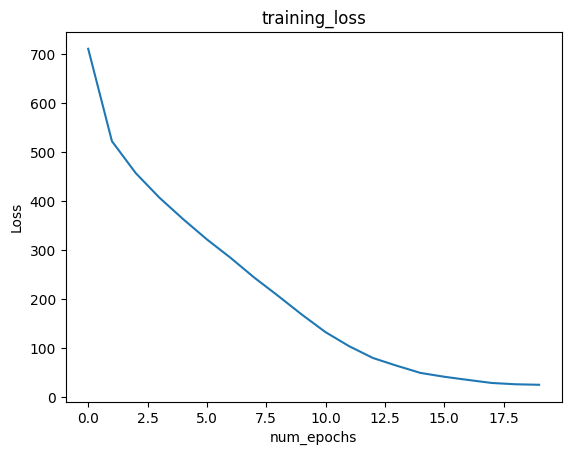

100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


In [23]:
model_mla = patch.S60_MLA(num_classes=num_classes, pretrained=False,drop_path_rate=drop_path,num_heads=num_heads,depth_token_only=depth_token_only)
print("MLA")
train(model_mla, train_loader, epochs=num_epochs,lr=lr,weight_decay=weight_decay)
acc1_mla, acc5_mla = evaluate(model_mla, test_loader)


MLA Low Rank


100%|██████████| 391/391 [00:58<00:00,  6.65it/s]


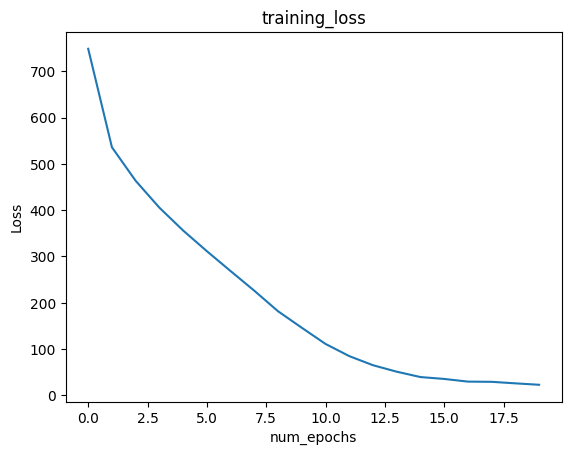

100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


In [24]:
model_mla_lr = patch.S60_MLA_LR(num_classes=num_classes, pretrained=False,drop_path_rate=drop_path,num_heads=num_heads,depth_token_only=depth_token_only,low_rank_dim = low_rank_dim)
print("MLA Low Rank")
train(model_mla_lr, train_loader, epochs=num_epochs,lr=lr,weight_decay=weight_decay)
acc1_mla_lr, acc5_mla_lr = evaluate(model_mla_lr, test_loader)

In [29]:
print("🔍 Porównanie:")
print(f"MLA  - Top1: {acc1_mla:.4f} | Top5: {acc5_mla:.4f}")
print(f"MLA       - Top1: {acc1_mla_lr:.4f} | Top5: {acc5_mla_lr :.4f}")

🔍 Porównanie:
MLA  - Top1: 0.6737 | Top5: 0.9628
MLA       - Top1: 0.6684 | Top5: 0.9608


MLA


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


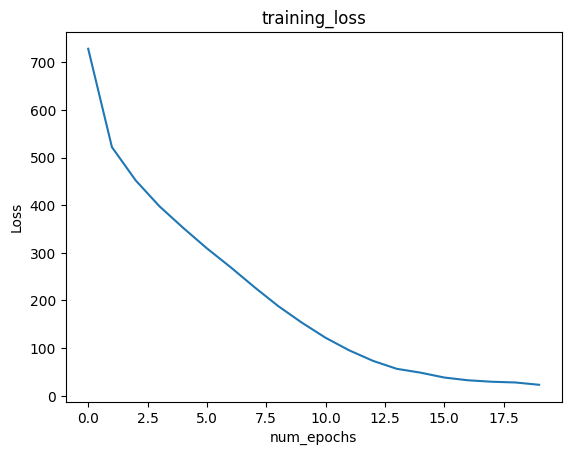

100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


In [30]:
model_mla = patch.S60_MLA(num_classes=num_classes, pretrained=False,drop_path_rate=drop_path,num_heads=num_heads,depth_token_only=depth_token_only)
print("MLA")
train(model_mla, train_loader, epochs=num_epochs,lr=lr,weight_decay=weight_decay)
acc1_mla, acc5_mla = evaluate(model_mla, test_loader)


MLA Low Rank


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


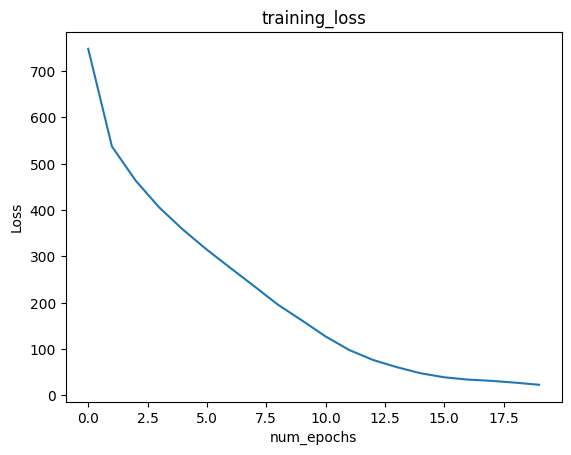

100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


In [31]:
model_mla_lr = patch.S60_MLA_LR(num_classes=num_classes, pretrained=False,drop_path_rate=drop_path,num_heads=num_heads,depth_token_only=depth_token_only,low_rank_dim = low_rank_dim)
print("MLA Low Rank")
train(model_mla_lr, train_loader, epochs=num_epochs,lr=lr,weight_decay=weight_decay)
acc1_mla_lr, acc5_mla_lr = evaluate(model_mla_lr, test_loader)

In [32]:
print("🔍 Porównanie:")
print(f"MLA  - Top1: {acc1_mla:.4f} | Top5: {acc5_mla:.4f}")
print(f"MLA       - Top1: {acc1_mla_lr:.4f} | Top5: {acc5_mla_lr :.4f}")

🔍 Porównanie:
MLA  - Top1: 0.6719 | Top5: 0.9679
MLA       - Top1: 0.6709 | Top5: 0.9619


MLA


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


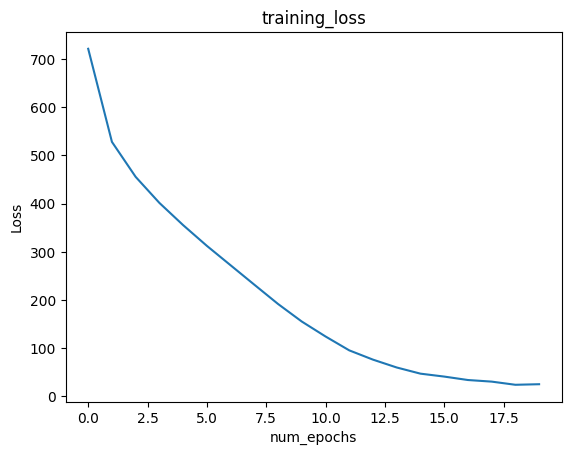

100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


In [33]:
model_mla = patch.S60_MLA(num_classes=num_classes, pretrained=False,drop_path_rate=drop_path,num_heads=num_heads,depth_token_only=depth_token_only)
print("MLA")
train(model_mla, train_loader, epochs=num_epochs,lr=lr,weight_decay=weight_decay)
acc1_mla, acc5_mla = evaluate(model_mla, test_loader)


MLA Low Rank


100%|██████████| 391/391 [00:59<00:00,  6.59it/s]


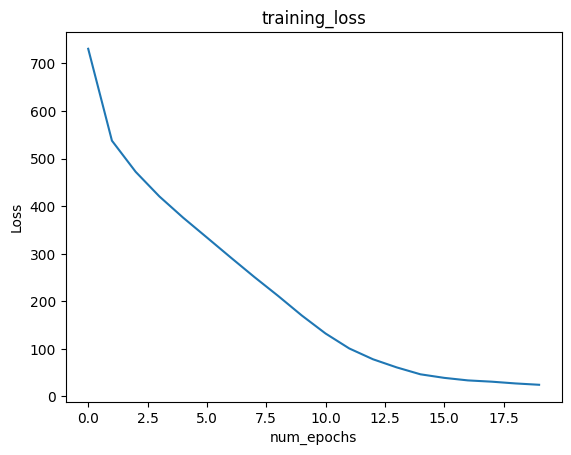

100%|██████████| 79/79 [00:15<00:00,  5.13it/s]


In [34]:
model_mla_lr = patch.S60_MLA_LR(num_classes=num_classes, pretrained=False,drop_path_rate=drop_path,num_heads=num_heads,depth_token_only=depth_token_only,low_rank_dim = low_rank_dim)
print("MLA Low Rank")
train(model_mla_lr, train_loader, epochs=num_epochs,lr=lr,weight_decay=weight_decay)
acc1_mla_lr, acc5_mla_lr = evaluate(model_mla_lr, test_loader)

In [35]:
print("🔍 Porównanie:")
print(f"MLA  - Top1: {acc1_mla:.4f} | Top5: {acc5_mla:.4f}")
print(f"MLA       - Top1: {acc1_mla_lr:.4f} | Top5: {acc5_mla_lr :.4f}")

🔍 Porównanie:
MLA  - Top1: 0.6637 | Top5: 0.9637
MLA       - Top1: 0.6734 | Top5: 0.9640
